# Problem 1

In [22]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB
import gurobipy as gb


In [23]:

# Load the dataset
advertising_data = pd.read_csv('HW2/Advertising Winter 2024.csv')
advertising_data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [24]:

# Preparing data for L1 regression
X = advertising_data[['TV', 'Radio', 'Newspaper']].values
y = advertising_data['Sales'].values

# Number of predictors
n = X.shape[0]




In [25]:

# Create a Gurobi model
model = Model()
#setting params for gurobi for clean outtput
model.Params.OutputFlag = 0

# Add variables for regression coefficients
b0 = model.addVar(name='b0', vtype=GRB.CONTINUOUS)
b1 = model.addVar(name='b1', vtype=GRB.CONTINUOUS)
b2 = model.addVar(name='b2', vtype=GRB.CONTINUOUS)
b3 = model.addVar(name='b3', vtype=GRB.CONTINUOUS)


# Add variables for the L1 loss
loss = model.addVars(n, lb=0, name='loss', vtype=GRB.CONTINUOUS)

# Objective function: minimize the sum of the L1 loss
model.setObjective(sum(loss[i] for i in range(n)), GRB.MINIMIZE)

# Constraints for the L1 loss
for i in range(n):
    model.addConstr(loss[i] >= y[i] - (b0+ b1*X[i,0] + b2*X[i,1] + b3*X[i,2]) )
    model.addConstr(loss[i] >= -y[i] +( b0+ b1*X[i,0] + b2*X[i,1] + b3*X[i,2]) )

# Solve the model
model.optimize()

# Print the regression coefficients
print('b0 =', b0.x)
print('b1 =', b1.x)
print('b2 =', b2.x)
print('b3 =', b3.x)

# Print the L1 loss
print('L1 loss =', model.objVal)


b0 = 3.2797893774713356
b1 = 0.04382140799173407
b2 = 0.1967413118206927
b3 = 0.0
L1 loss = 242.5118111550459


# Comparing these parameter estimates with that obtained in the previous homework (a linear regression model with an L2 loss function).



In [30]:
import  sklearn.linear_model
data = pd.read_csv('HW2/Advertising Winter 2024.csv')

#training the whole data model on linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
x = data.drop(['Sales'], axis=1)
y = data['Sales']

model_lr=sklearn.linear_model.LinearRegression()
model_lr.fit(x,y)

#printing the parameters
print('intercept:', model_lr.intercept_)
print('slope:', model_lr.coef_)

intercept: 3.005209420097845
slope: [-0.00057983  0.04577592  0.18838318 -0.00124333]


In [33]:
print('Coefficients using L1 Loss function:')
print('b0 =', b0.x)
print('b1 =', b1.x)
print('b2 =', b2.x)
print('b3 =', b3.x)
print('Coefficients using L2 Loss function :')
print('b0 =', model_lr.intercept_)
print('b1 =', model_lr.coef_[0])
print('b2 =', model_lr.coef_[1])
print('b3 =', model_lr.coef_[2])


Coefficients using L1 Loss function:
b0 = 3.2797893774713356
b1 = 0.04382140799173407
b2 = 0.1967413118206927
b3 = 0.0
Coefficients using L2 Loss function :
b0 = 3.005209420097845
b1 = -0.0005798278087352247
b2 = 0.04577591959744511
b3 = 0.1883831759769336


### The variation in coefficients between L1 and L2 regularization is due to the different penalty terms they add to the loss function, which affects the magnitude and sparsity of the resulting coefficients. L1 regularization is more likely to result in some coefficients being exactly zero, which is useful for feature selection, while L2 regularization results in smaller but non-zero coefficients across the board

# Problem 2

It is, in general, a good idea to test a machine learning model on a simple
simulated test dataset to ensure the model works as intended. The make blobs function in
scikit-learn can be used to generate data-points simulated from multivariate normal dis-
tributions. Your first task is to use the make blobs function to generate 500 observations
(𝑥,𝑦)with two predictor variables and one outcome variable. Set centers = 2. For each
observation 𝑖, 𝑦𝑖denotes the class of observations it belongs to.



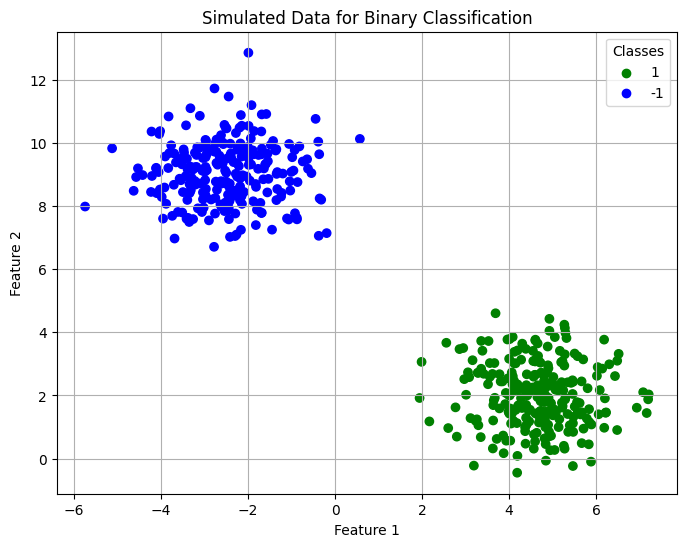

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


# Generate dataset
X, y = make_blobs(n_samples=500, centers=2, n_features=2, random_state=42)

# Transform y to have values -1 and 1 instead of 0 and 1
y = 2 * y - 1

# Plotting with color coding and legend
plt.figure(figsize=(8, 6))
colors = ['green' if y_value == 1 else 'blue' for y_value in y]
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title("Simulated Data for Binary Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

# Adding legend
plt.scatter([], [], c='green', label='1')
plt.scatter([], [], c='blue', label='-1')
plt.legend(title="Classes")

# Show the plot
plt.show()




Q- Visualize the data and visually identify whether the observations can be separated with
a linear classifier.

A- Both clusters are separable using a linear classifier (line) as can be seen from the plot above

# Linear Classifier using Gurobi

Implement a linear classifier by formulating and solving the optimization problem
discussed in the lecture using Gurobi. Verify whether your implementation correctly
predicts whether the dataset simulated in the previous step can be classified using a linear
classifier.



### Maximize:
$$\epsilon$$

### Constraints



$$ (\sum_{j=1}^{n} \alpha_{j} \cdot X_{ij} + \beta) \cdot y_{i} \geq \epsilon \quad \forall i \in \{1, ..., m\}$$

Additionally, to ensure convergence to a single solution, constrain as follows: 
$$ \epsilon < 10 $$

Here:
- $\alpha_{j}$ are the variables representing the weights for each feature $j$ in the dataset.
- $X_{ij}$ is the value of feature $j$ for data point $i$.
- $\beta$ is the variable representing the bias term.
- $y_{i}$ is the label of the $i$-th data point, indicating its class.
- $\epsilon$ is the variable representing the margin between the classes that the model aims to maximize, subject to the constraints that ensure correct classification of the data points with at least this margin. It is further constrained to ensure it does not exceed 10, aiding in the model's convergence to a single solution.
- $n$ is the number of features.
- $m$ is the number of data points in the dataset.



In [14]:
n = X.shape[1]

## Defining the model to maximize the margin
model = Model('Max Margin')
model.Params.OutputFlag = 0

## Creating the variables
beta = model.addVar(name='beta', vtype=GRB.CONTINUOUS,lb=-GRB.INFINITY ,ub= GRB.INFINITY)
alpha = model.addVars(n,name='alphas', vtype=GRB.CONTINUOUS,lb=-GRB.INFINITY ,ub= GRB.INFINITY)
epsilon = model.addVar(name='epsilon', vtype=GRB.CONTINUOUS,ub= 10)

## Adding the objective function to maximize the margin
model.setObjective(epsilon, GRB.MAXIMIZE)

# Adding the constraints
for i in range(len(X)):
    model.addConstr((gb.quicksum(alpha[j] * X[i][j] for j in range(n)) + beta ) * y[i] >= epsilon, "Constraint_Pos_{}".format(i))


## Solving the model
model.optimize()

## Printing the results
print('Optimal Solution:')
print('beta = {}'.format(beta.x))
print('alpha = {}'.format([alpha[i].x for i in range(n)]))
# Printing the objective function value
print('Optimal Objective Function Value: {}'.format(model.objVal))


Optimal Solution:
beta = 15.409302965542064
alpha = [2.873414261226155, -3.4770167725089234]
Optimal Objective Function Value: 10.0


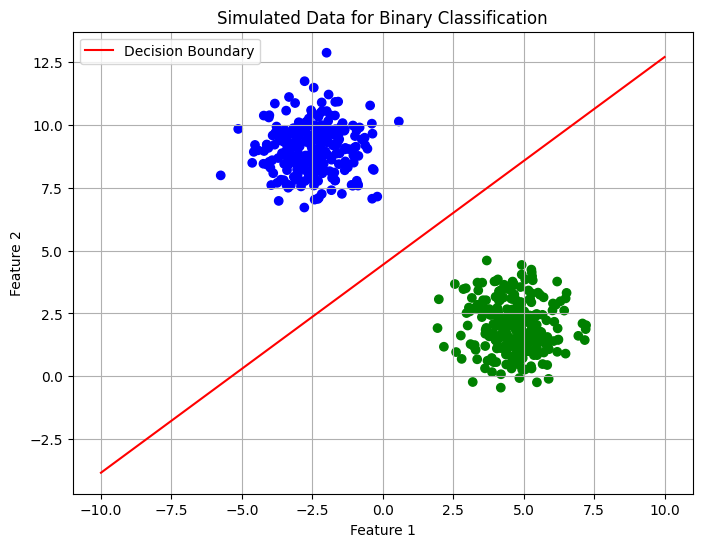

In [16]:
# Plotting the decision boundary
plt.figure(figsize=(8, 6))
colors = ['green' if y_value == 1 else 'blue' for y_value in y]
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title("Simulated Data for Binary Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

# Adding the decision boundary
x1 = np.linspace(-10, 10, 100)
x2 = - (beta.x + alpha[0].x * x1) / alpha[1].x
plt.plot(x1, x2, color='red', label='Decision Boundary')
plt.legend()

# Show the plot
plt.show()


It is verified that the model correctly predicts whether the dataset can be classified using a linear classifier. The model is able to classify the dataset with 100% accuracy.